# 8. 차원축소

- 특성이 늘어나면 좋은 솔루션을 찾기 어려움
- 차원 축소를 통해 훈련 속도를 높이거나 데이터 시각화에 용이하게 만들 수 있음
- 접근 방법: 투영(projectioin), 매니폴드 학습
- 축소 기법: PCA, 커널 PCA, LLE

## 8.1 차원의 저주
- 훈련 세트의 차원이 클수록 과대적합 위험이 커

## 8.2 차원 축소 접근 방법

### 8.2.1 투영(projection)
<img src='https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile1.uf.tistory.com%2Fimage%2F99EABC3E5B8A48781BEFA4'>

- 훈련 샘플과 평면 사이의 가장 짧은 직선을 따라 투영하여 2D 데이터셋을 얻음
- `스위스 롤` 데이터같이 뒤틀리거나 휜 데이터에서는 큰 효과가 없음

<img src='https://www.researchgate.net/profile/John-Burgoyne/publication/200688576/figure/fig1/AS:305995638165506@1449966453759/The-Swiss-roll-data-set-On-the-left-the-data-is-presented-in-its-original-form-On.png'>

### 8.2.2 매니폴드 학습

- d차원 매니폴드: d차원 초평면으로 보일 수 있는 n차원 공간의 일부(d<n)
- 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정에 근거해 매니폴드를 모델링하는 매니폴드 학습 진행
- 항상 더 낫거나 간단한 솔루션이 되는 건 아니며, 전적으로 데이터셋에 달림

## 8.3 PCA 주성분분석

- 데이터에 가장 가까운 초평면을 정의하고 평면에 투영시킴

### 8.3.1 분산 보존
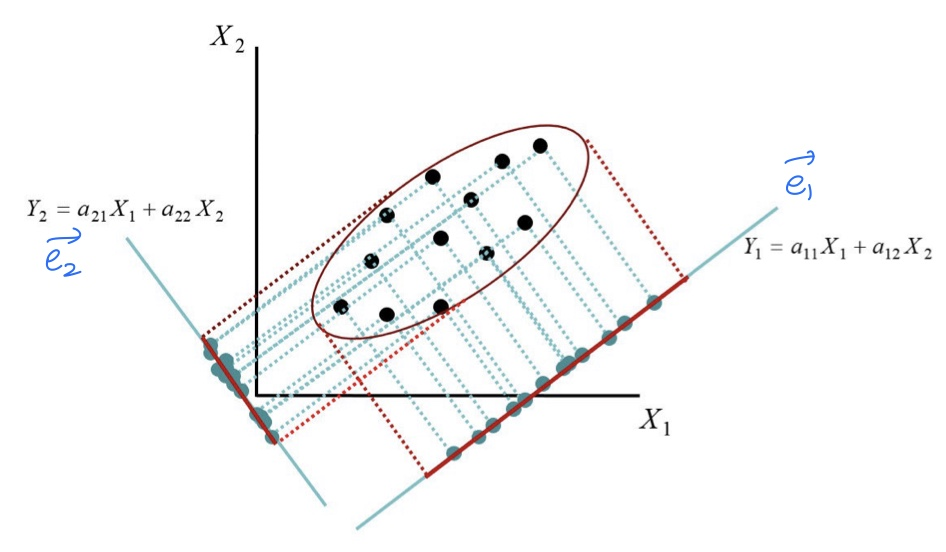
- 분산이 최대로 보존되는 축을 선택해야 정보 유실이 적음 > 평균 제곱 거리를 최소화하는 축

### 8.3.2 주성분

- i번째 축을 데이터의 i번째 주성분(pc)이라 함
- 특잇값 분해(SVD)로 행렬을 분해하여 주성분을 찾을 수 있음

In [1]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

svd()를 사용해 주성분을 구한 후 첫 2개의 pc를 정의하는 단위 벡터 추출

In [2]:
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

### 8.3.3 d차원으로 투여아기

- 첫 d개의 주성분으로 정의한 초평면에 투영하여 d차원으로 축소

In [3]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2) 
#PCA 변환 완료

### 8.3.4 사이킷런 사용하기

PCA 모델을 사용해 2차원으로 줄이는 코드(사이킷런은 자동으로 데이터를 중앙에 맞춰줌)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

`components_` 속성에 wd의 전치가 있음

### 8.3.5 설명된 분산의 비율

`explained_variance_ratio_`: 데이터셋의 분산 비율을 나타냄  
pc의 분산 비율을 따져 원 데이터를 얼마나 잘 나타내는지 확인 가능

In [5]:
pca.explained_variance_ratio_ # array([1 pc, 2 pc])

array([0.84248607, 0.14631839])

### 8.3.6 적절한 차원 수 선택

- 누적합이 충분한 분산(ex. 95%)에 도달할 때까지 더해야 할 차원 수를 선택하는 것이 간단

차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수 계산

In [6]:
import urllib.request
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [7]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95)+1

In [9]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

설명된 분산을 차원 수의 함수로 그려 변곡점(elbow) 전에 선택하는 방식도 있음

### 8.3.7 압축을 위한 PCA, pca 역변환

`재구성 오차`: 원본 데이터와 재구성된 데이터(압축 후 원복) 사이의 평균 제곱 거리  
`inverse_transform()`으로 복원

In [10]:
pca = PCA(n_components = 154) #154차원으로 압축
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced) #784차원으로 복원

In [11]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

NameError: name 'os' is not defined

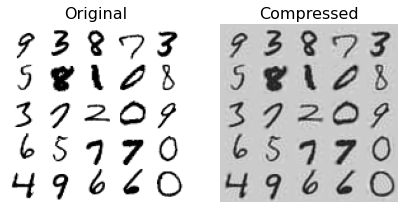

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

### 8.3.8 랜덤 PCA

- `svd_solver='randomized'`로 지정하면 확률적 알고리즘인 랜덤 pca를 사용해 첫 d개의 pc에 대한 근삿값을 빠르게 찾음(default: auto)
- d가 n보다 많이 작으면 SVD보다 훨씬 빠름
- 완전한 SVD 방식을 강제하려면 `svd_solver='full'`로 사용

In [13]:
rnd_pca = PCA(n_components = 154, svd_solver = 'randomized')
X_reduced = rnd_pca.fit_transform(X_train)

### 8.3.9 점진적 PCA

- 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 하나씩 주입
- 온라인으로 PCA를 적용할 수 있음

IncrementalPCA 클래스에 주입하여 차원을 줄임. 이 떄 fit()이 아니라 partial_fit()을 사용

In [14]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

IncrementalPCA는 특정 순간에 배열의 일부만 사용하기 때문에 메모리 부족 문제를 해결할 수 있음

## 8.4 커널 PCA

- 서포트 벡터 머신에서 사용했던 커널 트릭과 같은 기법을 PCA에 적용해 복잡한 비선형 투형을 수행
- projection 후 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때 유용

In [15]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

MemoryError: Unable to allocate 36.5 GiB for an array with shape (70000, 70000) and data type float64

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝

- kPCA는 비지도 학습이라 명확한 성능 측정 기준이 없음
- 차원 축소는 지도학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 커널/하이퍼 파라미터를 선택할 수 있음

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components = 2)),
    ('log_reg', LogisticRegression())
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

KeyboardInterrupt: 

In [ ]:
print(grid_search.best_params_)

`재구성 원상pre-image`: 선형 PCA를 역전시키면 원본 공간이 아닌 특성 공간에 데이터 포인트가 놓이게 됨. 특성 공간은 무한 차원이라 실제 에러를 계산할 수 없지만, 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있음.
  
- 원상을 얻게 되면 오차를 최소화하는 커널과 하이퍼파라미터를 선택할 수 있음
- 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 훈련시키는 것으로 재구성
- `fit_inverse_transform=True` 로 지정하면 자동으로 수행

In [ ]:
rbf_pca = KernelPCA(n_componets = 2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf.pca.inverse_transform(X_reduced)

In [ ]:
# 재구성 원상 오차 계산
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

## 8.5 LLE 지역 선형 임베딩

- 비선형 차원 축소
- 투영에 의존하지 않는 매니폴드 학습
- 각 훈련 샘플이 최근접 이웃에 얼마나 선형적으로 연관되어있는지 측정하고 국부적 관계가 잘 보존되는 훈련 세트의 저차원 표현을 찾음
- 꼬인 매니폴드를 펼치는 데 잘 작동함

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)

## 8.6 다른 차원 축소 기법

- `랜덤 투영`: 랜덤한 선형 투영으로 데이터를 저차원 공간으로 투영. 초기 차원수에는 의존적이지 않음.
- `다차원 스케일링(MDS)`: 샘플 간 거리를 보존하며 차원 축소
- `Isomap`: 샘플을 가까운 이웃과 연결하여 그래프를 만들고 샘플 간 지오데식 거리를 유지하며 차원 축소
- `t-SNE`: 비슷한 샘플은 가까이, 그렇지 않으면 멀리하며 차원 축소. 주로 시각화에 많이 사용되며 고차원 공간의 샘플 군집 시각화에 사용
- `선형판별분석(LDA)`: 분류 알고리즘이지만 훈련 과정에서 클래스 사이를 잘 구분하는 축을 학습. 데이터가 투영되는 초평면을 정의하는 데 축을 사용할 수 있음.